# EV Charging Infrastructure Data Collection and Exploration

This notebook handles the collection and initial exploration of:
1. Existing charging stations (OpenChargeMap API)
2. Potential new locations (OpenStreetMap)

The collected data will be used for demand analysis and optimization in subsequent notebooks.

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import folium

from src.data.api_client import APIClient
from src.data.constants import *
from src.data.utils import *
from src.visualization import map_viz

# Initialize API client
client = APIClient()

## 1. Data Collection
First, let's collect data from both APIs and save it for future use.

In [7]:
# Fetch charging stations data
print("Collecting existing charging stations data...")
stations_df = client.fetch_charging_stations()

# Fetch potential locations data
print("\nCollecting potential locations data...")
potential_df = client.fetch_potential_locations()

# Save raw data
timestamp = grab_time()
raw_data = {
    'charging_stations': (stations_df, CHARGING_STATIONS_DIR),
    'potential_locations': (potential_df, POTENTIAL_LOCATIONS_DIR)
}

for name, (df, dir_path) in raw_data.items():
    output_file = dir_path / f'{name}_{timestamp}.csv'
    df.to_csv(output_file, index=False)
    print(f"\nSaved {name} data to {output_file}")

Fetching charging station data...
Found 132 stations in KW region

Fetching potential locations data...
Found 3551 potential locations in KW region

Geometry types found:
geometry_type
Polygon    3509
Point        42
Name: count, dtype: int64

Saved charging_stations data to /u1/a9dutta/co370/kw-ev-charging-optimization/data/raw/charging_stations/charging_stations_2024-11-12_05-22-12.csv

Saved potential_locations data to /u1/a9dutta/co370/kw-ev-charging-optimization/data/raw/potential_locations/potential_locations_2024-11-12_05-22-12.csv


## 2. Data Quality Analysis
Let's examine the quality of our collected data.

In [9]:
def analyze_data_quality(df: pd.DataFrame, name: str) -> None:
    """Analyze and display data quality metrics."""
    print(f"\n{name} Data Quality Analysis:")
    print("-" * 50)
    print(f"Total records: {len(df)}")
    print("\nColumns present:")
    for col in df.columns:
        missing = df[col].isnull().sum()
        print(f"- {col}: {df[col].dtype} ({missing} missing values)")
    
    if 'location_type' in df.columns:
        print("\nLocation types:")
        print(df['location_type'].value_counts())
    
    if 'charger_type' in df.columns:
        print("\nCharger types:")
        print(df['charger_type'].value_counts())

# Analyze both datasets
stations_df = pd.read_csv(get_latest_csv(CHARGING_STATIONS_DIR)[0])
potential_df = pd.read_csv(get_latest_csv(POTENTIAL_LOCATIONS_DIR)[0])
for df, name in [(stations_df, "Charging Stations"), 
                 (potential_df, "Potential Locations")]:
    analyze_data_quality(df, name)


Charging Stations Data Quality Analysis:
--------------------------------------------------
Total records: 132

Columns present:
- name: object (0 missing values)
- latitude: float64 (0 missing values)
- longitude: float64 (0 missing values)
- num_chargers: int64 (0 missing values)
- charger_type: object (0 missing values)
- operator: object (0 missing values)
- address: object (0 missing values)
- city: object (0 missing values)
- postal_code: object (1 missing values)
- usage_cost: object (0 missing values)
- data_source: object (0 missing values)
- location_type: object (0 missing values)

Location types:
location_type
charging_station    132
Name: count, dtype: int64

Charger types:
charger_type
Level 2    121
Level 3     11
Name: count, dtype: int64

Potential Locations Data Quality Analysis:
--------------------------------------------------
Total records: 3551

Columns present:
- name: object (3228 missing values)
- latitude: float64 (0 missing values)
- longitude: float64 (0 m

## 3. Geographic Distribution
Let's visualize the spatial distribution of charging infrastructure and potential locations.
Due to the large number of locations, we'll create separate maps for clarity and performance.

In [18]:
# 3.1 Existing Charging Stations
print("Generating map of existing charging stations...")
m_existing = map_viz.create_kw_map()
m_existing = map_viz.plot_charging_stations(m_existing, stations_df)
m_existing

Generating map of existing charging stations...


The map above shows only existing charging stations. Note the current coverage and any obvious gaps.

In [19]:
# 3.2 Potential Locations by Type
# Create separate maps for different types of potential locations
location_types = potential_df['location_type'].unique()

for loc_type in location_types:
    print(f"\nGenerating map for {loc_type} locations...")
    type_df = potential_df[potential_df['location_type'] == loc_type]
    
    m_type = map_viz.create_kw_map()
    type_gdf = gpd.GeoDataFrame(
        type_df,
        geometry=gpd.points_from_xy(type_df.longitude, type_df.latitude)
    )
    m_type = map_viz.plot_potential_locations(m_type, type_gdf)
    display(m_type)
    print(f"Total {loc_type} locations: {len(type_df)}")



Generating map for parking locations...


Total parking locations: 2827

Generating map for fuel locations...


Total fuel locations: 42

Generating map for retail locations...


Total retail locations: 556

Generating map for cafe locations...


Total cafe locations: 16

Generating map for fast_food locations...


Total fast_food locations: 16

Generating map for restaurant locations...


Total restaurant locations: 17

Generating map for doctors locations...


Total doctors locations: 1

Generating map for commercial locations...


Total commercial locations: 54

Generating map for marketplace locations...


Total marketplace locations: 1

Generating map for pharmacy locations...


Total pharmacy locations: 8

Generating map for pub locations...


Total pub locations: 1

Generating map for bank locations...


Total bank locations: 5

Generating map for product_pickup locations...


Total product_pickup locations: 1

Generating map for community_centre locations...


Total community_centre locations: 1

Generating map for taxi locations...


Total taxi locations: 1

Generating map for brothel locations...


Total brothel locations: 1

Generating map for dentist locations...


Total dentist locations: 1

Generating map for cinema locations...


Total cinema locations: 1

Generating map for drinking_water locations...


Total drinking_water locations: 1


In [22]:
# 3.3 Strategic Overview Map
# Create a map with existing stations and clustered potential locations
print("\nGenerating strategic overview map...")

# Cluster potential locations
from sklearn.cluster import KMeans
n_clusters = 20  # Adjust based on your needs

# Perform clustering
coords = potential_df[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
potential_df['cluster'] = kmeans.fit_predict(coords)

# Calculate cluster centers and sizes
cluster_info = pd.DataFrame()
for cluster in range(n_clusters):
    mask = potential_df['cluster'] == cluster
    cluster_info.loc[cluster, 'latitude'] = potential_df[mask]['latitude'].mean()
    cluster_info.loc[cluster, 'longitude'] = potential_df[mask]['longitude'].mean()
    cluster_info.loc[cluster, 'size'] = mask.sum()

# Create overview map
m_overview = map_viz.create_kw_map()

# Add existing stations
m_overview = map_viz.plot_charging_stations(m_overview, stations_df)

# Add cluster centers with size-based markers
for _, cluster in cluster_info.iterrows():
    folium.CircleMarker(
        location=[cluster['latitude'], cluster['longitude']],
        radius=np.sqrt(cluster['size']),  # Scale marker size with number of locations
        color='blue',
        fill=True,
        popup=f"Potential Locations Cluster:<br>{cluster['size']} locations",
        fill_opacity=0.6
    ).add_to(m_overview)

m_overview



Generating strategic overview map...


The strategic overview map above shows:
- Red markers: Existing charging stations
- Blue circles: Clusters of potential locations (size indicates number of locations)

This visualization helps identify:
1. Areas with high concentration of potential locations
2. Gaps in current coverage
3. Strategic opportunities for new stations

## 4. Charging Infrastructure Analysis
Analyze the current charging infrastructure in detail.

Charging Station Analysis:
--------------------------------------------------

Charger Types by Operator:
charger_type                 Level 2  Level 3
operator                                     
ChargePoint                       38        1
Circle K                           0        1
EV Connect                         0        1
Jule                               0        1
SWTCH - Charge Everywhere         14        0
Sun Country Highway                2        0
Tesla (Tesla-only charging)        7        0
Tesla (including non-tesla)        0        1
Unknown                           24        1
flo                               36        5

Average Chargers per Station by Type:
                  mean  count
charger_type                 
Level 2       1.016529    121
Level 3       2.181818     11

Coverage Metrics (Area: 442.1 km²):
Stations per km²: 0.299
Chargers per km²: 0.333


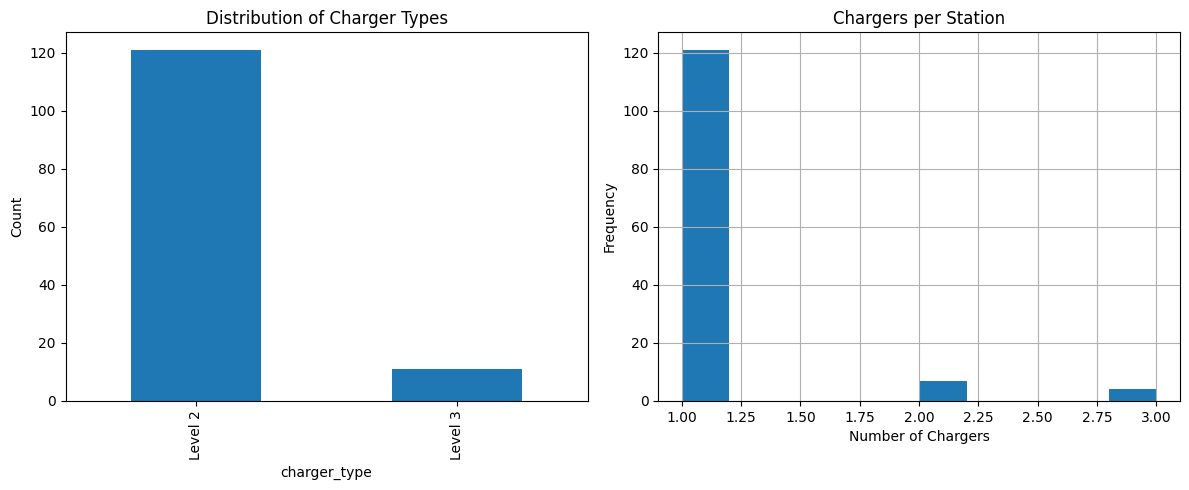

In [11]:
# Charging station statistics
print("Charging Station Analysis:")
print("-" * 50)
print("\nCharger Types by Operator:")
print(pd.crosstab(stations_df['operator'], stations_df['charger_type']))

print("\nAverage Chargers per Station by Type:")
print(stations_df.groupby('charger_type')['num_chargers'].agg(['mean', 'count']))

# Calculate density metrics
area_km2 = (KW_BOUNDS['north'] - KW_BOUNDS['south']) * (KW_BOUNDS['east'] - KW_BOUNDS['west']) * 111 * 111
print(f"\nCoverage Metrics (Area: {area_km2:.1f} km²):")
print(f"Stations per km²: {len(stations_df)/area_km2:.3f}")
print(f"Chargers per km²: {stations_df['num_chargers'].sum()/area_km2:.3f}")

# Visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stations_df['charger_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Charger Types')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
stations_df['num_chargers'].hist(bins=10)
plt.title('Chargers per Station')
plt.xlabel('Number of Chargers')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Potential Locations Analysis
Analyze the distribution and characteristics of potential new locations.

Potential Locations Analysis:
--------------------------------------------------

Location Types:
location_type
parking             2827
retail               556
commercial            54
fuel                  42
restaurant            17
fast_food             16
cafe                  16
pharmacy               8
bank                   5
marketplace            1
doctors                1
pub                    1
product_pickup         1
community_centre       1
taxi                   1
brothel                1
dentist                1
cinema                 1
drinking_water         1
Name: count, dtype: int64

Identified 3 location clusters


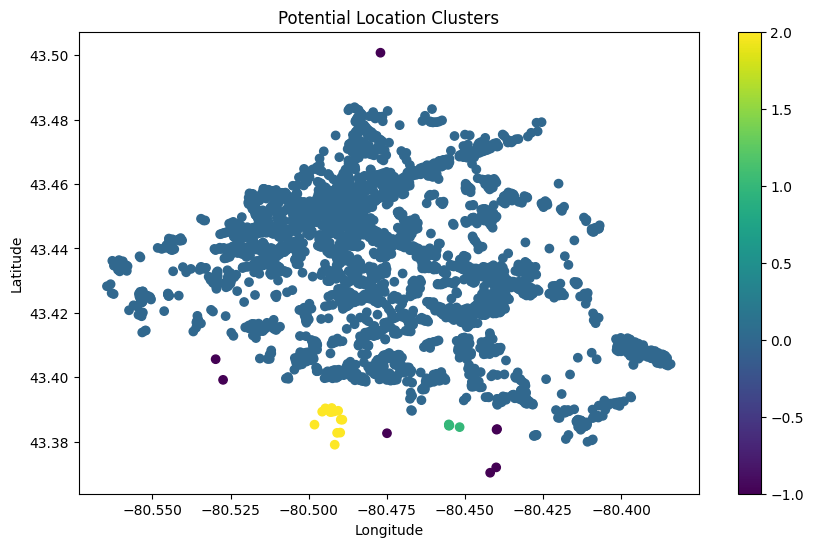

In [12]:
# Potential locations statistics
print("Potential Locations Analysis:")
print("-" * 50)

print("\nLocation Types:")
print(potential_df['location_type'].value_counts())

# Analyze spatial clustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Cluster locations to identify concentrated areas
coords = potential_df[['latitude', 'longitude']].values
coords_scaled = StandardScaler().fit_transform(coords)
clusters = DBSCAN(eps=0.3, min_samples=3).fit_predict(coords_scaled)

potential_df['cluster'] = clusters
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"\nIdentified {n_clusters} location clusters")

# Visualize clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(potential_df['longitude'], 
                     potential_df['latitude'],
                     c=potential_df['cluster'], 
                     cmap='viridis')
plt.colorbar(scatter)
plt.title('Potential Location Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 5.5 Detailed Infrastructure Analysis
Let's analyze the specific characteristics of our charging infrastructure and potential locations.

In [7]:
# Operator Analysis
stations_df = pd.read_csv(get_latest_csv(CHARGING_STATIONS_DIR)[0])
potential_df = pd.read_csv(get_latest_csv(POTENTIAL_LOCATIONS_DIR)[0])
print("Operator Analysis:")
print("-" * 50)
print("\nCharging Stations by Operator:")
print(stations_df['operator'].value_counts())

# Operator and Charger Type Relationship
operator_charger_cross = pd.crosstab(
    stations_df['operator'], 
    stations_df['charger_type'],
    margins=True
)
print("\nCharger Types by Operator:")
print(operator_charger_cross)

# Charger Efficiency Analysis
charger_stats = stations_df.groupby('charger_type').agg({
    'num_chargers': ['count', 'mean', 'sum']
}).round(2)
charger_stats.columns = ['Stations', 'Avg Chargers/Station', 'Total Chargers']

print("\nCharger Type Statistics:")
print(charger_stats)

# Location Type Analysis
print("\nPotential Location Types:")
type_counts = potential_df['location_type'].value_counts()
type_percentages = (type_counts / len(potential_df) * 100).round(1)
for loc_type, count in type_counts.items():
    percentage = type_percentages[loc_type]
    print(f"{loc_type}: {count} locations ({percentage}%)")

# Regional Coverage Analysis
print("\nRegional Coverage Analysis:")
print("-" * 50)
# Calculate actual KW region area using bounds
area_km2 = (KW_BOUNDS['north'] - KW_BOUNDS['south']) * \
           (KW_BOUNDS['east'] - KW_BOUNDS['west']) * \
           111 * 111  # Rough conversion to km²

print(f"Study Area: {area_km2:.1f} km²")
print(f"Current Infrastructure:")
print(f"- Stations per km²: {len(stations_df)/area_km2:.3f}")
print(f"- Chargers per km²: {stations_df['num_chargers'].sum()/area_km2:.3f}")
print(f"Potential Infrastructure:")
print(f"- Potential locations per km²: {len(potential_df)/area_km2:.3f}")
print(f"- Total locations per km² if all developed: {(len(stations_df) + len(potential_df))/area_km2:.3f}")

Operator Analysis:
--------------------------------------------------

Charging Stations by Operator:
operator
flo                            41
ChargePoint                    39
Unknown                        25
SWTCH - Charge Everywhere      14
Tesla (Tesla-only charging)     7
Sun Country Highway             2
Tesla (including non-tesla)     1
EV Connect                      1
Jule                            1
Circle K                        1
Name: count, dtype: int64

Charger Types by Operator:
charger_type                 Level 2  Level 3  All
operator                                          
ChargePoint                       38        1   39
Circle K                           0        1    1
EV Connect                         0        1    1
Jule                               0        1    1
SWTCH - Charge Everywhere         14        0   14
Sun Country Highway                2        0    2
Tesla (Tesla-only charging)        7        0    7
Tesla (including non-tesla)        0

## 6. Distance Analysis
Analyze distances between existing stations and potential new locations.

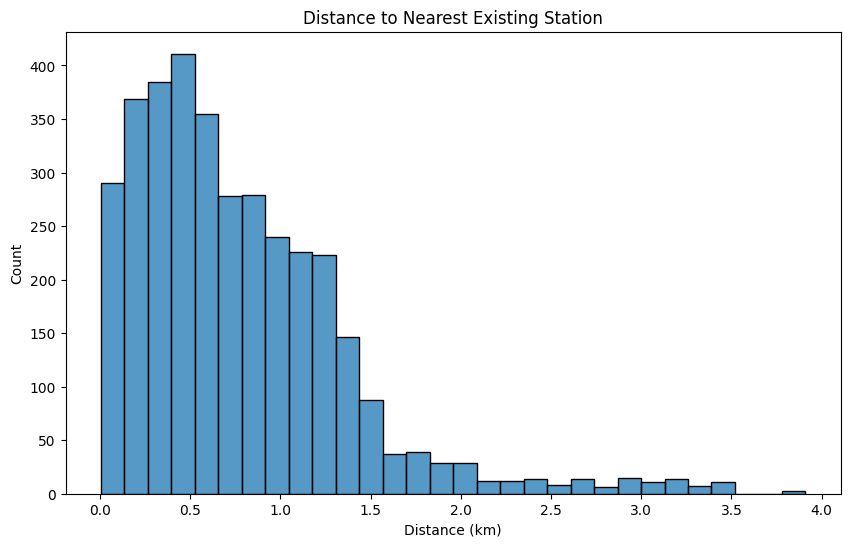


Distance Statistics (km):
count    3551.000000
mean        0.775508
std         0.597621
min         0.005115
25%         0.338466
50%         0.641598
75%         1.074782
max         3.910097
Name: min_distance_to_station, dtype: float64


In [13]:
def calculate_distances(point, locations_df):
    """Calculate distances from point to all locations."""
    return np.sqrt(
        (locations_df['latitude'] - point['latitude'])**2 +
        (locations_df['longitude'] - point['longitude'])**2
    ) * 111  # Convert to kilometers

# Calculate minimum distances
min_distances = []
for _, potential in potential_df.iterrows():
    distances = calculate_distances(potential, stations_df)
    min_distances.append(distances.min())

potential_df['min_distance_to_station'] = min_distances

# Analyze distance distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=potential_df, x='min_distance_to_station', bins=30)
plt.title('Distance to Nearest Existing Station')
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.show()

print("\nDistance Statistics (km):")
print(potential_df['min_distance_to_station'].describe())

## 7. Save Processed Data
Save the processed and analyzed data for use in subsequent analysis.

In [14]:
# Combine relevant analysis results
potential_df['processed_timestamp'] = timestamp

# Save processed data
processed_file = PROCESSED_DATA_DIR / f'analyzed_locations_{timestamp}.csv'
potential_df.to_csv(processed_file, index=False)
print(f"Saved processed data to {processed_file}")

Saved processed data to /u1/a9dutta/co370/kw-ev-charging-optimization/data/processed/analyzed_locations_2024-11-12_05-22-12.csv


## 8. Key Findings

In [17]:
print("1. Current Infrastructure:")
print(f"- {len(stations_df)} existing charging stations")
print(f"- Average of {stations_df['num_chargers'].mean():.1f} chargers per station")
print(f"- {stations_df['charger_type'].value_counts().iloc[0]} is the most common charger type")

print("\n2. Potential Locations:")
print(f"- {len(potential_df)} potential new locations identified")
print(f"- {n_clusters} distinct geographical clusters identified")
print(f"- Average distance to nearest existing station: {potential_df['min_distance_to_station'].mean():.2f} km")

print("\n3. Coverage Metrics:")
print(f"- Stations per km²: {len(stations_df)/area_km2:.3f}")
print(f"- Chargers per km²: {stations_df['num_chargers'].sum()/area_km2:.3f}")

1. Current Infrastructure:
- 132 existing charging stations
- Average of 1.1 chargers per station
- 121 is the most common charger type

2. Potential Locations:
- 3551 potential new locations identified
- 3 distinct geographical clusters identified
- Average distance to nearest existing station: 0.78 km

3. Coverage Metrics:
- Stations per km²: 0.299
- Chargers per km²: 0.333
